In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix


from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [26]:
# Read data
df = pd.read_csv('data_models/american_bankruptcy.csv')

In [27]:
df['status_label'] = np.where(df['status_label'] == 'alive', 1, 0)

In [28]:
df['status_label'].value_counts()

status_label
1    73462
0     5220
Name: count, dtype: int64

In [29]:
# Define X and y
X=df.drop(columns=['company_name','status_label','year'])
y=df['status_label']

In [30]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

In [31]:
# Baseline prediction
y.mean()

0.9336569990595054

In [32]:
# Correct class imbalances

# combine in a single dataframe
train_data = pd.concat([X_train, y_train], axis=1) 

# Separate the classes
class_0 = train_data[train_data[y_train.name] == 0] 
class_1 = train_data[train_data[y_train.name] == 1]

# Oversample y==0
class_0_oversampled = class_0.sample(len(class_1), replace=True, random_state=666)

# Combine balanced classes in a single dataframe
train_data_resampled = pd.concat([class_0_oversampled, class_1], axis=0)

#Shuffle the dataframe
train_data_resampled = train_data_resampled.sample(frac=1, random_state=666)

In [33]:
# Define new X and y variables after balancing classes

X_train_res = train_data_resampled.drop(y_train.name, axis=1)

y_train_res = train_data_resampled[y_train.name].astype('int64')

y_train_res.value_counts()

status_label
1    55096
0    55096
Name: count, dtype: int64

# **Prediction Models**

## Random Forest

In [25]:
p = X_train_res.shape[1]

params = {
    'max_depth': np.append(np.arange(1, 12), None),
    'max_features': np.arange(1, p + 1),
    'min_samples_leaf': np.arange(1, 31)
}

rf = RandomForestClassifier(n_estimators=100, random_state=666)
rs = RandomizedSearchCV(rf, params, n_iter=100, cv=5, scoring='accuracy', n_jobs=8, random_state=666)

In [27]:
%%time
# rs.fit(X_train_res, y_train_res) # only run if necessary

CPU times: user 43.3 s, sys: 1.17 s, total: 44.5 s
Wall time: 31min 35s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=666),
                   n_iter=100, n_jobs=8,
                   param_distributions={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, None], dtype=object),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18]),
                                        'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])},
                   random_state=666, scoring='accuracy')

In [28]:
print("Best parameters:", rs.best_params_)
print("Best score:", rs.best_score_)

Best parameters: {'min_samples_leaf': 5, 'max_features': 8, 'max_depth': None}
Best score: 0.992159134805376


In [31]:
# Test the model
best_rf = RandomForestClassifier(**rs.best_params_, random_state=666)
best_rf.fit(X_train_res, y_train_res)

y_pred_rf = best_rf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Test set accuracy: {test_accuracy:.4f}")

Test set accuracy: 0.9407


In [33]:
y_test.mean()

0.933658685374409

## XGBoost

In [35]:
params = {
    'max_depth': np.arange(3, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=666)

# Initialize RandomizedSearchCV for hyperparameter tuning
rs_xgb = RandomizedSearchCV(xgb_clf, params, n_iter=50, cv=5, scoring='accuracy', n_jobs=8, random_state=666)

# Fit the RandomizedSearchCV object to the resampled training data
rs_xgb.fit(X_train_res, y_train_res)

/Users/juanpena/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=666, ...),
                   n_iter=50, n_jobs=8,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': [100, 200, 300],
                                        'subsample': [0.8, 0.9, 1]},
                   random_state=666, scoring='accuracy')

In [36]:
print("Best parameters:", rs_xgb.best_params_)
print("Best score:", rs_xgb.best_score_)

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
Best score: 0.9885381840961823


In [37]:
# Use the best params to fit model and predict
best_xgb = xgb.XGBClassifier(**rs_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=666)

best_xgb.fit(X_train_res, y_train_res)

y_pred_xgb = best_xgb.predict(X_test)

test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"Test set accuracy XGBoost: {test_accuracy_xgb:.4f}")

Test set accuracy XGBoost: 0.9395


In [38]:
y_test.mean()

0.933658685374409

## SVM

In [42]:
# %%time
# pipe_svc = Pipeline([
#     ('scaler', StandardScaler()),
#     ('svc', SVC(random_state=666))
# ])

# param_grid_svc = {
#     'svc__C': [0.1, 1, 10],        # Regularization parameter
#     'svc__kernel': ['linear', 'rbf'], # Kernel type
#     'svc__gamma': ['scale', 'auto']   # Kernel coefficient for 'rbf'
# }

# gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=8)

# # Fit the GridSearchCV object to the resampled training data
# gs_svc.fit(X_train_res, y_train_res)

# # Print the best parameters and the corresponding score
# print("Best parameters:", gs_svc.best_params_)
# print("Best score:", gs_svc.best_score_)

# # Use the best estimator to make predictions on the test set
# y_pred_gs_svc = gs_svc.best_estimator_.predict(X_test)

# # Calculate the accuracy on the test set
# test_accuracy_gs_svc = accuracy_score(y_test, y_pred_gs_svc)

# print(f"Test set accuracy with GridSearchCV SVC: {test_accuracy_gs_svc:.4f}")

Best parameters: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best score: 0.6150809691904856
Test set accuracy with GridSearchCV SVC: 0.3687


In [41]:
%%time
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=666))
])

param_grid_svc = [
    {
        'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'svc__kernel': ['rbf']  # Kernel type
    },
    {
        'svc__C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
        'svc__kernel': ['poly'],  # Kernel type
        'svc__degree': np.arange(2, 8)  # Degree of the polynomial kernel
    }
]

gs_svc = GridSearchCV(pipe_svc, param_grid_svc, cv=5, scoring='accuracy', n_jobs=8)

# Fit the GridSearchCV object to the resampled training data
gs_svc.fit(X_train_res, y_train_res)

# Print the best parameters and the corresponding score
print("Best parameters:", gs_svc.best_params_)
print("Best score:", gs_svc.best_score_)

# Use the best estimator to make predictions on the test set
y_pred_gs_svc = gs_svc.best_estimator_.predict(X_test)

# Calculate the accuracy on the test set
test_accuracy_gs_svc = accuracy_score(y_test, y_pred_gs_svc)

print(f"Test set accuracy with GridSearchCV SVC: {test_accuracy_gs_svc:.4f}")

Best parameters: {'svc__C': 100, 'svc__kernel': 'rbf'}
Best score: 0.6324415799280587
Test set accuracy with GridSearchCV SVC: 0.4071
CPU times: user 3min 34s, sys: 2.31 s, total: 3min 36s
Wall time: 2h 32min 4s


## Neural Network

In [34]:
# Scale the data
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [35]:
# Define the neural network architecture
model6 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_res_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model6.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history6 = model6.fit(X_train_res_scaled, y_train_res,
                    validation_data=(X_test_scaled, y_test),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_accuracy = model6.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/50


/Users/juanpena/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 304us/step - accuracy: 0.5956 - loss: 0.6527 - val_accuracy: 0.4815 - val_loss: 0.6553
Epoch 2/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.6318 - loss: 0.6195 - val_accuracy: 0.4712 - val_loss: 0.6578
Epoch 3/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 296us/step - accuracy: 0.6447 - loss: 0.6074 - val_accuracy: 0.6867 - val_loss: 0.6094
Epoch 4/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6579 - loss: 0.5939 - val_accuracy: 0.7617 - val_loss: 0.5694
Epoch 5/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6609 - loss: 0.5877 - val_accuracy: 0.7521 - val_loss: 0.5482
Epoch 6/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 294us/step - accuracy: 0.6676 - loss: 0.5811 - val_accuracy: 0.6778 - val_loss: 0.5712
Epoch 7/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 291us/step - accuracy: 0.6727 - loss: 0.5756 - val_accuracy: 0.8343 - val_loss: 0.4815
Epoch 8/50
3444/3444 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - accuracy: 0.6791 - loss: 0.56

In [37]:
# Predict the labels for the test set
y_pred = model6.predict(X_test_scaled)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

615/615 ━━━━━━━━━━━━━━━━━━━━ 0s 215us/step
Confusion Matrix:
[[  594   711]
 [ 2549 15817]]


**Confussion Matrix:**
- Accuracy: (TP + TN) / (TP + FP + FN + TN) = (594 + 15817) / (594 + 711 + 2549 + 15817) = 0.84
- Precision: TP / (TP + FP) = 594 / (594 + 711) = 0.45
- Recall: TP / (TP + FN) = 594 / (594 + 2549) = 0.19
- F1 Score: 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.45 * 0.19) / (0.45 + 0.19) = 0.27

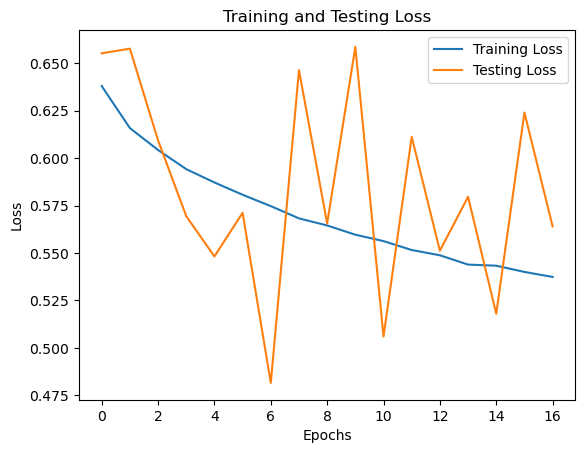

In [38]:

# Plot
plt.plot(history6.history['loss'], label='Training Loss')
plt.plot(history6.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


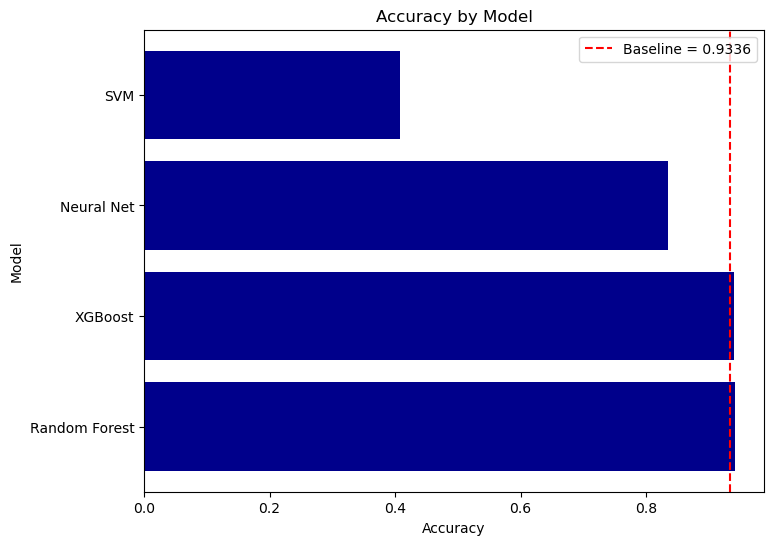

In [5]:
# Accuracy plot
models = ['Random Forest', 'XGBoost', 'Neural Net', 'SVM']
accuracies = [0.9407, 0.9395, 0.8343, 0.4071]
baseline = 0.9336

plt.figure(figsize=(8, 6))
plt.barh(models, accuracies, color='darkblue')
plt.axvline(x=baseline, color='red', linestyle='--', label=f'Baseline = {baseline}')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Accuracy by Model')
plt.legend()
plt.show()